CLIP(Contrastive Language-Image Pre-training) 모델과 ChromaDB를 사용하여 텍스트 기반 유사 이미지 검색(Vision RAG) 시스템을 구축하고 실행하는 과정

핵심은 이미지와 텍스트를 동일한 벡터 공간(Embedding Space)에 임베딩하여, 텍스트 쿼리와 의미적으로 가장 가까운 이미지(벡터)를 데이터베이스에서 찾아냄

In [ ]:
# 멀티모달 기본 이해 - 이미지를 읽어 LLM이 설명
!pip install -U langchain langchain-core langchain-community langchain-google-genai google-genai
!pip install -U sentence-transformers
!pip install -U chromadb

In [ ]:
import base64
from pathlib import Path
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage
import os
from sentence_transformers import SentenceTransformer, util # CLIP 임베딩 모델을 사용하기 위한 라이브러리
import torch
from chromadb import PersistentClient # 벡터 데이터베이스 (Vector DB) 클라이언트
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableLambda
from dotenv import load_dotenv
from google.colab import userdata # Colab 환경에서 보안 정보를 가져오기 위해 userdata 모듈 임포트
from typing import List, Dict, Any
from pathlib import Path
from PIL import Image
from langchain_core.output_parsers import StrOutputParser
load_dotenv() # .env 파일에서 환경 변수를 로드 (Colab 환경에서는 userdata가 더 자주 사용됨)


# Gemini 모델 초기화 및 설정
llm = ChatGoogleGenerativeAI(
    temperature=0.2,  # 모델의 창의성(무작위성)을 0.2로 설정 (낮은 값은 더 결정론적이고 일관된 응답을 유도)
    model="gemini-2.5-flash", # 이미지 분석에 최적화된 빠른 멀티모달 모델 사용
    google_api_key=userdata.get('GOOGLE_API_KEY') # Colab의 보안 저장소에서 API 키를 가져와 설정
)

In [ ]:
IMG_DIR = "img_db" # 이미지 파일이 저장될 로컬 디렉토리 이름
CHROMA_DIR = ".chroma_image_demo" # ChromaDB의 데이터가 저장될 로컬 디렉토리 이름
COLLECTION = "image_docs" # ChromaDB 내에서 벡터를 저장할 컬렉션(테이블과 유사) 이름


# 이미지용 / 텍스트용 모델을 분리
IMG_MODEL_NAME = "clip-Vit-B-32" # CLIP 모델 중 하나로 이미지와 텍스트를 같은 벡터 공간으로 매핑하는 멀티 모델 모달(Vision Transformer 기반)
# 이미지 -> 벡터, 텍스트 ->벡터 . 두 벡터를 비교해서 의미적으로 유사함 정도 파악. 이미지 검색, 캐셔닝, Vision RAG 등에 사용

TEXT_MODEL_NAME = "sentence-transformers/clip-Vit-B-32-multilingual-v1" # 텍스트 인코더 (다국어 지원 CLIP 모델)

img_model = SentenceTransformer(IMG_MODEL_NAME) # 이미지 임베딩용 모델 객체 초기화
text_model = SentenceTransformer(TEXT_MODEL_NAME) # 텍스트 임베딩용 모델 객체 초기화

client = PersistentClient(path=CHROMA_DIR) # ChromaDB 클라이언트 초기화 (데이터를 로컬 파일에 지속적으로 저장)
collection = client.get_or_create_collection(name=COLLECTION) # 벡터 저장을 위한 컬렉션 생성 또는 가져오기

In [ ]:
# 이미지 목록 반환

def list_imgFunc(root:str, exts=('.jpg', '.jpeg', '.png','.webp')) -> List[str]:
  # 지정된 루트 폴더(root) 아래의 모든 하위 디렉토리를 포함하여 이미지 파일 경로를 수집
  return [str(p) for p in Path(root).rglob('*') if p.suffix.lower in exts]  # p.suffix.lower()로 소문자 비교하도록 수정

# 벡터 DB 구축 : 이미지들을 CLIP 임베딩으로 저장
def build_img_dbFunc():
  Path(IMG_DIR).mkdir(parents=True, exist_ok=True)  # 이미지 저장 디렉토리가 없으면 생성
  paths = list_imgFunc(IMG_DIR)
  print(paths)
  if not paths:
    print('해당 폴더에 이미지가 없어요')
    return
# 이미지 DB를 새로 구축할 때 기존 레코드 전체 삭제 후 새로 구축
  existing = collection.get(include=[])  #include를 비우면 chroma는 id만 반환
  ids_to_delete = existing.get('ids', [])
  if ids_to_delete:
    collection.delete(ids=ids_to_delete)
    print(f'기본{len(ids_to_delete)}개 레코드 삭제 완료')

  print(f'{len(paths)}개 이미지 로딩중...')
  # PIL.Image 리스트를 이미지용 모델로 임베딩
  imgs = [Image.open(p).convert("RGB") for p in paths]  # 이미지 로드 및 RGB 포맷으로 변환 (CLIP 표준 입력)
  vecs = img_model.encode(imgs, normalize_embeddings=True).tolist() # CLIP 모델로 이미지 벡터화 및 정규화
  ids = [f'img_{i}' for i in range(len(paths))] # ChromaDB에 저장할 고유 ID 생성
  metadatas = [{'path':p} for p in paths] # 원본 파일 경로를 메타데이터로 저장
  collection.add(ids=ids, embeddings=vecs, metadatas=metadatas) # Chroma 컬렉션에 이미지 벡터와 메타데이터를 저장
  print('벡터DB에 이미지 저장 완료')

  print('벡터DB에 저장된 메타 데이터 일부 출력')
  got = collection.get(include=['metadatas'])
  for i,(id_, m) in enumerate(zip(got.get('ids',[]), got.get('metadatas',[])),1):
      print(f' {i}. id={id_}, path={m.get('path')}')
      if i >= 3: break


# 텍스트 -> 이미지 검색 (Retrieval)
def retrieve_imgFunc(query:str, top_k:int = 3) -> Dict[str, Any]:
  # CLIP모델로 텍스트를 벡터화해서 Chroma에 저장된 유사 이미지 검색 후 top_k개 반환
  q_vec = text_model.encode([query], normalize_embeddings=True).tolist()[0] # 쿼리를 임베딩 및 정규화
  res = collection.query(
      query_embeddings=[q_vec],   # 검색을 위한 쿼리 임베딩
      n_results = top_k,          # 검색할 이미지 개수
      include = ['metadatas', 'distances'], # 메타데이터(경로)와 거리 값 포함 요청
  )
  # 검색 결과 파싱 (ChromaDB의 결과 구조를 이해하는 것이 중요)
  metas = res['metadatas'][0] if res['metadatas'] else []
  dists = res['distances'][0] if res['distances'] else []
  paths = [m.get('path','?') for m in metas] # 메타데이터에서 이미지 경로 추출
  # 검색 결과를 딕셔너리 형태로 반환
  return{
      "query":query,
      "img_paths":paths,
      "metadatas":metas,
      "distances":dists,
  }

# 출력을 보기 좋게
def debug_print_retrieveFunc(result:Dict[str, Any]):
  print("\n--- 이미지 검색 결과 --- ")
  print('질의 : ', result['query'])
  print("검색 결과 :")
  for i,(p, d) in enumerate(zip(result['img_paths'], result['distances']), 1):
    print(f' {i}. {p}, 거리: {d:.4f}')  # 거리는 벡터 간의 거리. 값이 작을수록 유사함.

def show_img(result:Dict[str, Any], max_cols:int=3):
  paths = result['img_paths']
  if not paths:
    print('표시할 이미지 없음')
    return
  for i, p, in enumerate(paths, 1):
    try:
      img = Image.open(p).convert("RGB")
      print(f'{i}.{p}')
      display(img)  # Colab/Jupyter 환경에서 이미지를 출력하는 함수 (일반 Python 스크립트에서는 작동하지 않을 수 있음)
    except Exception as e :
      print(f'{i}.{p} 이미지 없음 로딩 실패 :{e}')

# 랭체인 구성
parser = StrOutputParser()  # LLM 응답을 단순 문자열로 파싱하는 아웃풋 파서
prompt = ChatPromptTemplate.from_messages([
    # system역할
    ("system",
     "너는 이미지 추천 도우미야."
     "주어진 설명(query)에 어울리는 내용을 누구든지 이해할 수 있도록 한국어로 설명해"
    ),
    # user 역할
    ("user",
     "사용자 설명 : {query}\n\n"
     "추천된 이미지 경로들 : \n{img_paths}\n\n"
     "각 이미지가 어떤 분위기 또는 내용 인지, 장면은 어떠한지 등을 친절하게 설명해 "

    )
])


# LCEL (LangChain Expression Language) 체인 정의: RAG 파이프라인
image_search_chain = (
    RunnableLambda(lambda q:retrieve_imgFunc(q, top_k=3)) # 쿼리를 받아 이미지 검색 및 경로 반환
    | prompt  # 검색 결과(이미지 경로)를 프롬프트 템플릿에 주입
    | llm     # LLM(Gemini)이 프롬프트를 바탕으로 설명을 생성 (Generation)
    | parser  # LLM 응답을 문자열로 변환
)

def run_Func():
  print('1) 이미지 DB구축')
  build_img_dbFunc()

  print('2) 텍스트로 유사 이미지 검색')
  q =  "따뜻한 느낌의 이미지"
  # q = input('검색어를 입력하세요: ')
  result = retrieve_imgFunc(q, top_k=3)
  print(result)
  debug_print_retrieveFunc(result)
  show_img(result)

  print('3) 랭체인으로 텍스트 검색 결과를 LLM이 설명')
  explain = image_search_chain.invoke(q)
  print('추천 결과 설명 ====')
  print(explain)

* CLIP과 벡터 데이터베이스의 심층 이해


    Vision RAG (Retrieval-Augmented Generation)

    1. 임베딩 공간(Embedding Space) : CLIP은 이미지와 텍스트를 고차원 벡터로 변환하여 두 데이터 유형이 의미적 유사성을 기준으로 배열된 공간을 만든다. 이 공간을 이해하는 것은 비정형 데이터 분석의 핵심

    2. 코사인 유사도(Cosine Similarity) : ChromaDB는 기본적으로 벡터 간의 거리(Distance)를 계산하여 유사도를 측정한다. 임베딩 벡터를 정규화(normalize_embeddings=True)하면 거리는 각도에 기반한 코사인 유사도와 밀접하게 관련된다. 벡터의 방향이 의미를 결정하고, 그 방향이 유사할수록 데이터가 관련성이 높다는 뜻.

    3. 영속성 클라이언트 (PersistentClient) : PersistentClient(path=CHROMA_DIR)를 사용하면 한 번 구축한 벡터 DB를 저장해두고, 코드를 다시 실행해도 재구축할 필요 없이 데이터를 바로 로드하여 사용할 수 있다. *  이는 실무에서 데이터 파이프라인의 효율성을 높이는 중요한 요소!


* 추가 공부 내용 - 파이프라인 확장 및 서비스화

      1. 데이터 수집 자동화:

      list_imgFunc로 이미지를 수동으로 넣는 대신, 웹 크롤링(BeautifulSoup, Scrapy)이나 클라우드 스토리지(S3, GCS)에서 이미지를 자동으로 가져와 build_img_dbFunc를 주기적으로 실행하는 스케줄러(예: Apache Airflow, Prefect)를 연결하기!

      2. API 엔드포인트 구축:

      FastAPI나 Flask와 같은 경량 웹 프레임워크를 사용하여 retrieve_imgFunc를 실행하는 API 엔드포인트를 만든다.
      사용자가 웹 페이지에서 텍스트를 입력하면 (Client), FastAPI 서버가 image_search_chain.invoke(q)를 실행하고 결과를 웹 페이지로 반환(Server)하는 구조를 만들기. 이는 편하게 일하는 데이터 서비스를 만드는 기초.

      3. 성능 최적화:

      sentence-transformers 대신 TensorFlow/Keras 기반으로 CLIP 모델을 로드하고 임베딩을 계산하는 방식으로 코드를 변경하여 하드웨어 가속(GPU)을 활용하는 연습도 하기



1) 이미지 DB구축
[]
해당 폴더에 이미지가 없어요
2) 텍스트로 유사 이미지 검색
{'query': '따뜻한 느낌의 이미지', 'img_paths': ['img_db/person.jpeg', 'img_db/petimage.jpg', 'img_db/image2.jpg'], 'metadatas': [{'path': 'img_db/person.jpeg'}, {'path': 'img_db/petimage.jpg'}, {'path': 'img_db/image2.jpg'}], 'distances': [1.540507197380066, 1.558459997177124, 1.560464859008789]}

--- 이미지 검색 결과 --- 
질의 :  따뜻한 느낌의 이미지
검색 결과 :
 1. img_db/person.jpeg, 거리: 1.5405
 2. img_db/petimage.jpg, 거리: 1.5585
 3. img_db/image2.jpg, 거리: 1.5605
1.img_db/person.jpeg


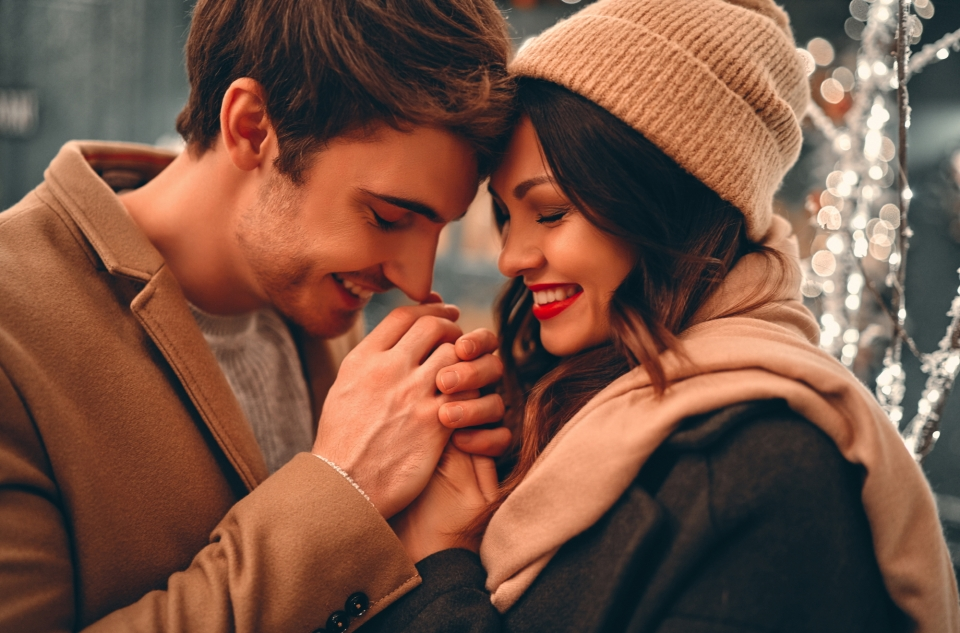

2.img_db/petimage.jpg


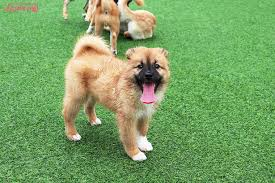

3.img_db/image2.jpg


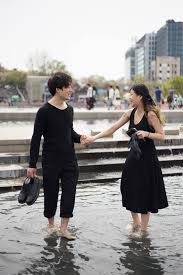

3) 랭체인으로 텍스트 검색 결과를 LLM이 설명
추천 결과 설명 ====
안녕하세요! '따뜻한 느낌의 이미지'를 찾으시는군요. 추천해 드린 이미지 경로들을 바탕으로 각 이미지가 어떤 분위기와 내용을 담고 있을지 친절하게 설명해 드릴게요.

---

### 1. `img_db/person.jpeg`

*   **분위기/내용:** 이 이미지는 아마도 **따뜻한 미소를 짓고 있는 사람의 모습**일 것 같아요. 부드러운 햇살이 비치거나, 아늑한 실내에서 편안한 표정을 짓고 있는 장면을 상상해 볼 수 있습니다.
*   **장면:** 사랑하는 사람과의 다정한 순간, 혹은 혼자만의 평화로운 휴식 시간일 수도 있고요. 온화하고 포근한 기운을 전달해 주어 보는 사람의 마음까지 따뜻하게 만들어 줄 거예요.

---

### 2. `img_db/petimage.jpg`

*   **분위기/내용:** 이 이미지는 **사랑스러운 반려동물의 모습**이 담겨 있을 것 같습니다. 따뜻한 햇살 아래서 낮잠을 자고 있거나, 주인의 품에 안겨 편안하게 쉬고 있는 강아지나 고양이의 모습일 수 있어요.
*   **장면:** 부드러운 털과 순수한 눈빛이 마음을 녹여주는 듯한 포근함을 선사할 거예요. 반려동물 특유의 순수하고 사랑스러운 매력이 보는 이에게 따뜻한 위로와 행복감을 줄 것입니다.

---

### 3. `img_db/image2.jpg`

*   **분위기/내용:** 이 이미지는 아마도 **아늑하고 평화로운 분위기**를 담고 있을 것 같아요. 특정 대상보다는 전체적인 색감이나 구도에서 따뜻함이 느껴지는 장면일 수 있습니다.
*   **장면:** 따뜻한 차 한 잔이 놓인 창가 풍경, 은은한 조명이 비추는 거실, 혹은 노을 지는 하늘 아래 펼쳐진 아름다운 풍경 등 다양한 장면을 상상해 볼 수 있습니다. 보는 것만으로도 마음이 편안해지고 온기가 느껴지는 순간을 포착했을 거예요.

---

이 이미지들은 모두 '따뜻한 느낌'이라는 사용자님의 요청에 맞춰, 시각적으로나 감성적으로 포근함을 전달해

In [ ]:
if __name__ == '__main__':
  run_Func()